In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)



C:\Users\railc\AppData\Local\Temp\ipykernel_29052\935847844.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


['measurement', 'station']

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station



In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(f"The most recent date in the dataset is: {most_recent_date}")


The most recent date in the dataset is: 2017-08-23


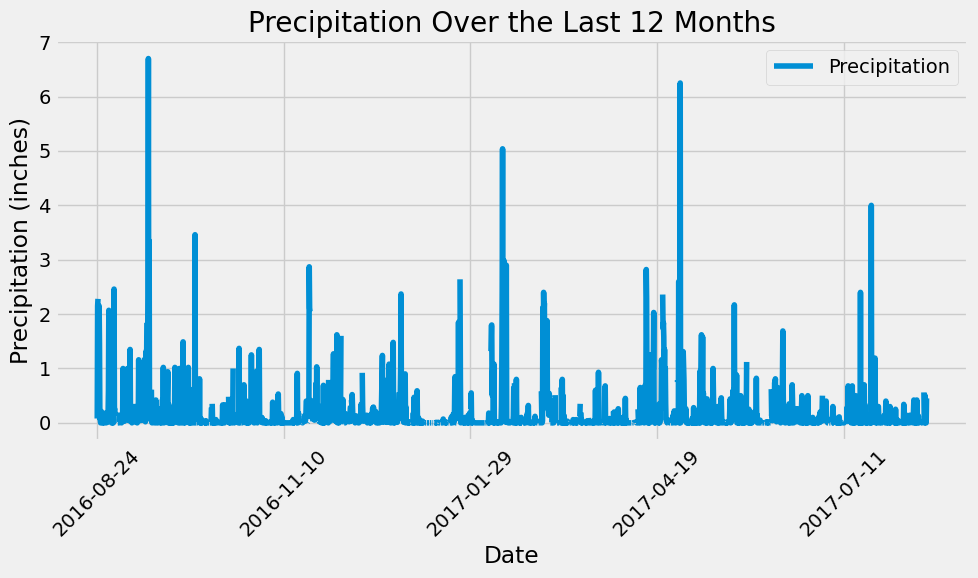

In [12]:
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)


precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()


precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])


precipitation_df = precipitation_df.sort_values(by='Date')


precipitation_df.plot(x='Date', y='Precipitation', figsize=(10,6))
plt.title("Precipitation Over the Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary_stats = precipitation_df['Precipitation'].describe()
print(precipitation_summary_stats)


count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"The total number of stations in the dataset is: {total_stations}")


The total number of stations in the dataset is: 9


In [15]:
# Design a query to find the most active stations
# List the stations and their counts in descending order
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).all()

for station in most_active_stations:
    print(f"Station ID: {station[0]}, Observations Count: {station[1]}")


Station ID: USC00519281, Observations Count: 2772
Station ID: USC00519397, Observations Count: 2724
Station ID: USC00513117, Observations Count: 2709
Station ID: USC00519523, Observations Count: 2669
Station ID: USC00516128, Observations Count: 2612
Station ID: USC00514830, Observations Count: 2202
Station ID: USC00511918, Observations Count: 1979
Station ID: USC00517948, Observations Count: 1372
Station ID: USC00518838, Observations Count: 511


In [16]:
# Get the most active station ID from the previous query
most_active_station_id = most_active_stations[0][0]

# Design a query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                    filter(Measurement.station == most_active_station_id).all()

# Extract the results
lowest_temp = temperature_stats[0][0]
highest_temp = temperature_stats[0][1]
avg_temp = temperature_stats[0][2]

print(f"For the most active station (Station ID: {most_active_station_id}):")
print(f"Lowest Temperature: {lowest_temp} F")
print(f"Highest Temperature: {highest_temp} F")
print(f"Average Temperature: {avg_temp:.2f} F")


For the most active station (Station ID: USC00519281):
Lowest Temperature: 54.0 F
Highest Temperature: 85.0 F
Average Temperature: 71.66 F


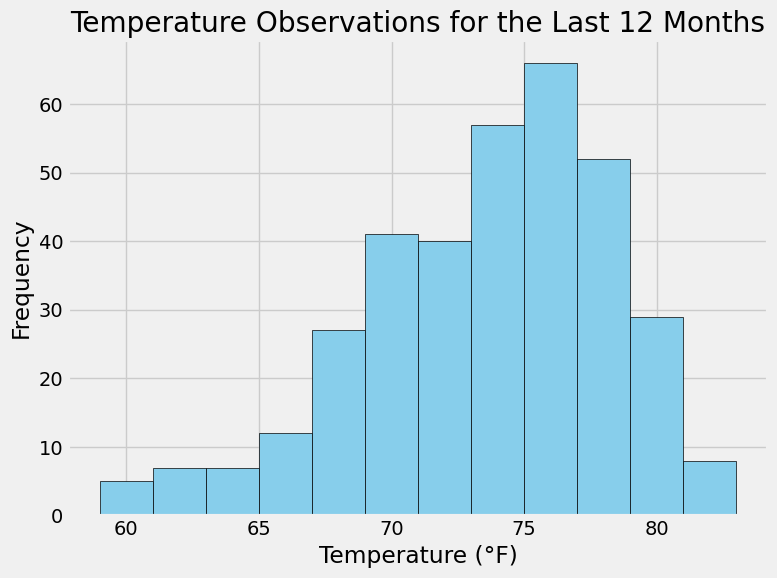

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)


tobs_data = session.query(Measurement.tobs).\
            filter(Measurement.station == most_active_station_id).\
            filter(Measurement.date >= one_year_ago).all()


tobs_df = pd.DataFrame(tobs_data, columns=['TOBS'])


plt.figure(figsize=(8, 6))
plt.hist(tobs_df['TOBS'], bins=12, color='skyblue', edgecolor='black')
plt.title('Temperature Observations for the Last 12 Months')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()



# Close Session

In [19]:
# Close Session
session.close()